In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

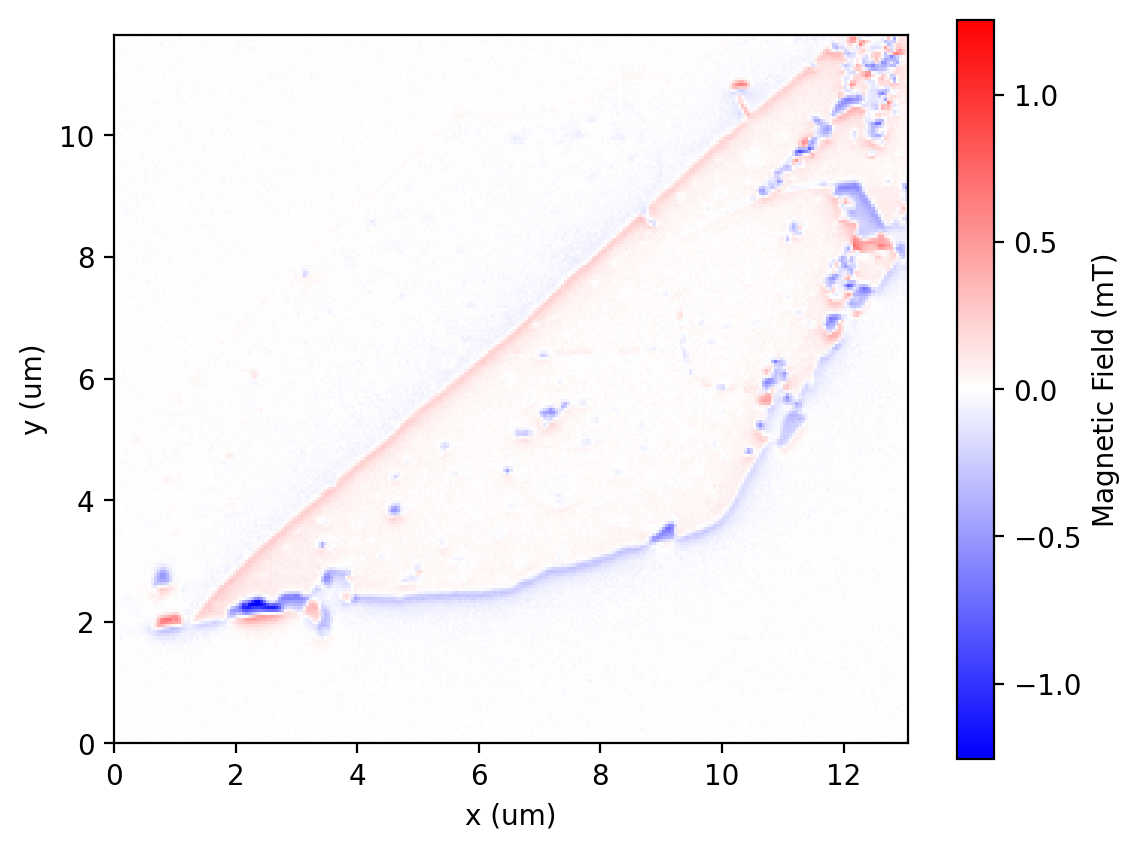

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

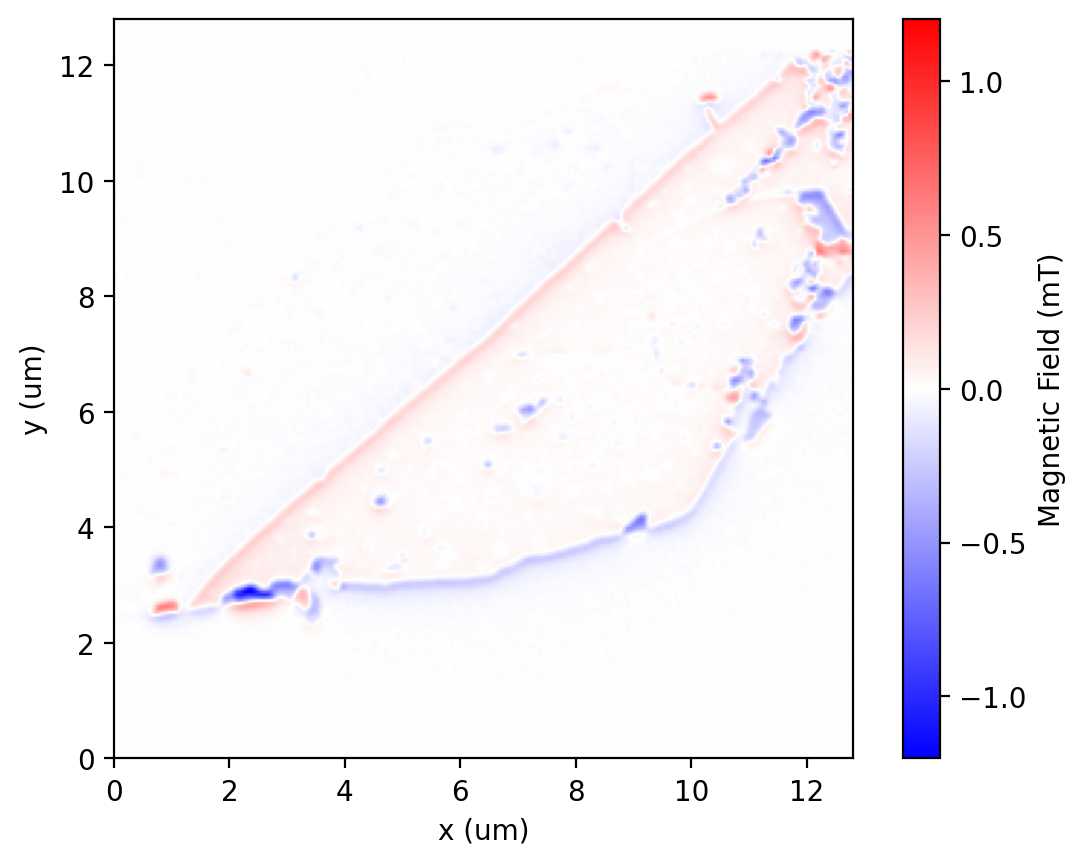

In [6]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transfor Bsensor into Bxyz

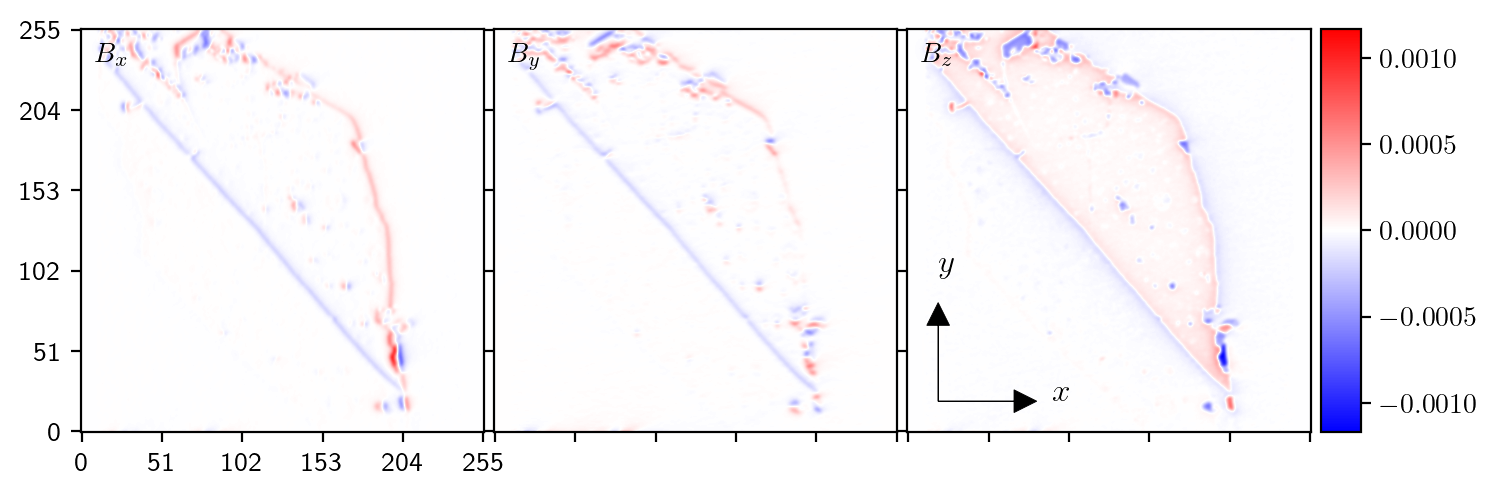

In [7]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Now we will try to reconstruct the magnetisation using a neural network.

In [17]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

dataset4 = copy.deepcopy(dataset)
dataset4.target = dataset4.target

Model = UniformMagnetisation(dataset4, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = FCNN(Model, dataset4)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1


In [18]:
FittingMethod.fit(n_epochs=150)

epoch     1 | loss on last mini-batch:  3.91e+03
epoch    11 | loss on last mini-batch:  3.91e+03
epoch    21 | loss on last mini-batch:  3.90e+03
epoch    31 | loss on last mini-batch:  3.78e+03
epoch    41 | loss on last mini-batch:  2.70e+03
epoch    51 | loss on last mini-batch:  1.62e+03
epoch    61 | loss on last mini-batch:  9.53e+02
epoch    71 | loss on last mini-batch:  5.52e+02
epoch    81 | loss on last mini-batch:  3.27e+02
epoch    91 | loss on last mini-batch:  2.04e+02
epoch   101 | loss on last mini-batch:  1.35e+02
epoch   111 | loss on last mini-batch:  9.44e+01
epoch   121 | loss on last mini-batch:  6.93e+01
epoch   131 | loss on last mini-batch:  5.29e+01
epoch   141 | loss on last mini-batch:  4.15e+01


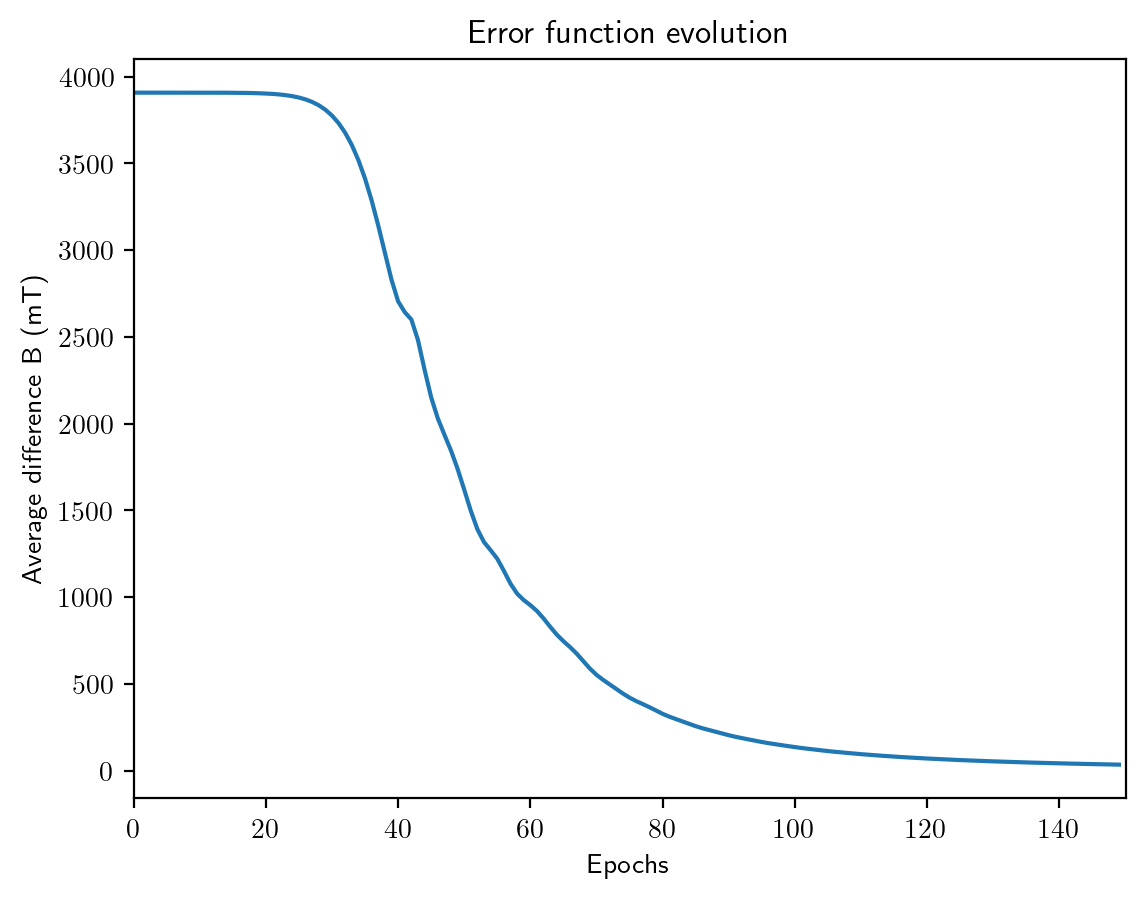

In [19]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


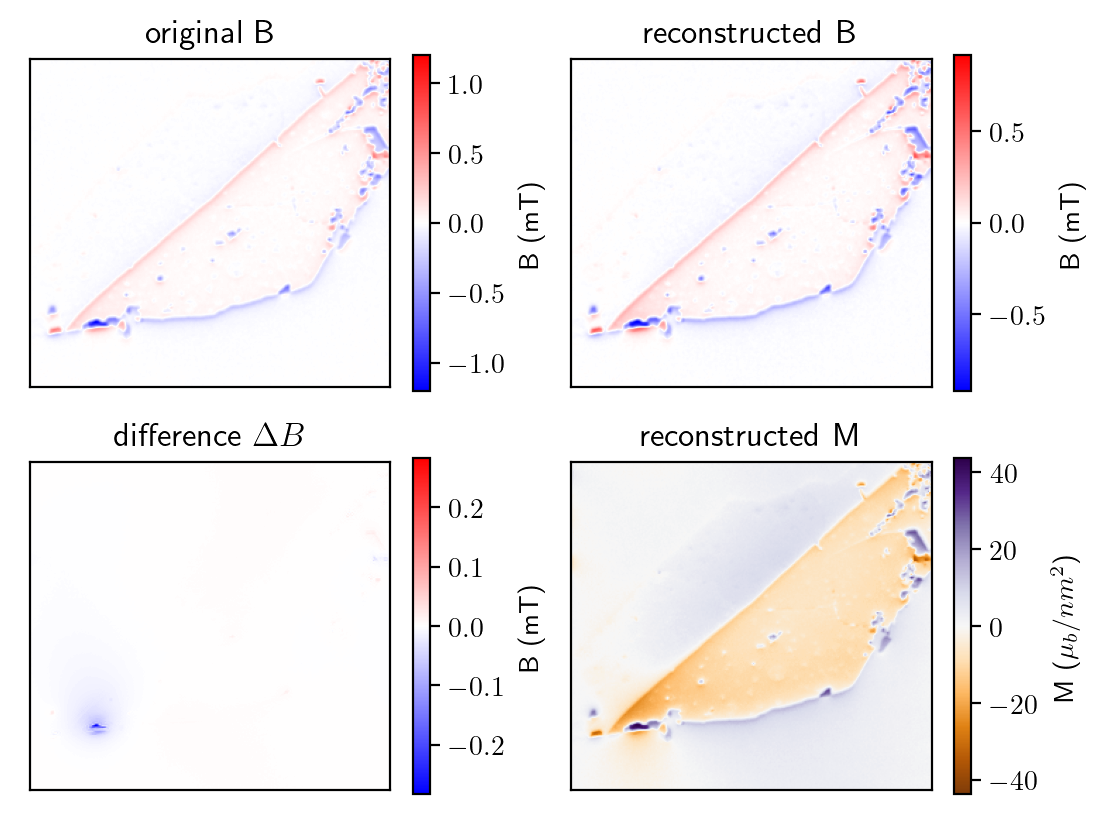

In [20]:
FittingMethod.extract_results()
FittingMethod.plot_results()

# Now try recon in Fourier space

In [ ]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMxyFspace import UniformMxyFspace as Mrecon

dataset5 = copy.deepcopy(dataset)
dataset5.target = dataset5.target

Model = Mrecon(dataset5, "MSE", m_theta = 0, m_phi = 0)

FittingMethod = FCNN(Model, dataset5)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1


In [ ]:
FittingMethod.fit(n_epochs=150)

epoch     1 | loss on last mini-batch:  8.42e+02
epoch    11 | loss on last mini-batch:  8.42e+02
epoch    21 | loss on last mini-batch:  8.41e+02
epoch    31 | loss on last mini-batch:  8.13e+02
epoch    41 | loss on last mini-batch:  5.98e+02
epoch    51 | loss on last mini-batch:  4.39e+02
epoch    61 | loss on last mini-batch:  2.89e+02
epoch    71 | loss on last mini-batch:  2.04e+02
epoch    81 | loss on last mini-batch:  1.46e+02
epoch    91 | loss on last mini-batch:  1.11e+02
epoch   101 | loss on last mini-batch:  8.79e+01
epoch   111 | loss on last mini-batch:  7.18e+01
epoch   121 | loss on last mini-batch:  6.00e+01
epoch   131 | loss on last mini-batch:  5.07e+01
epoch   141 | loss on last mini-batch:  4.30e+01


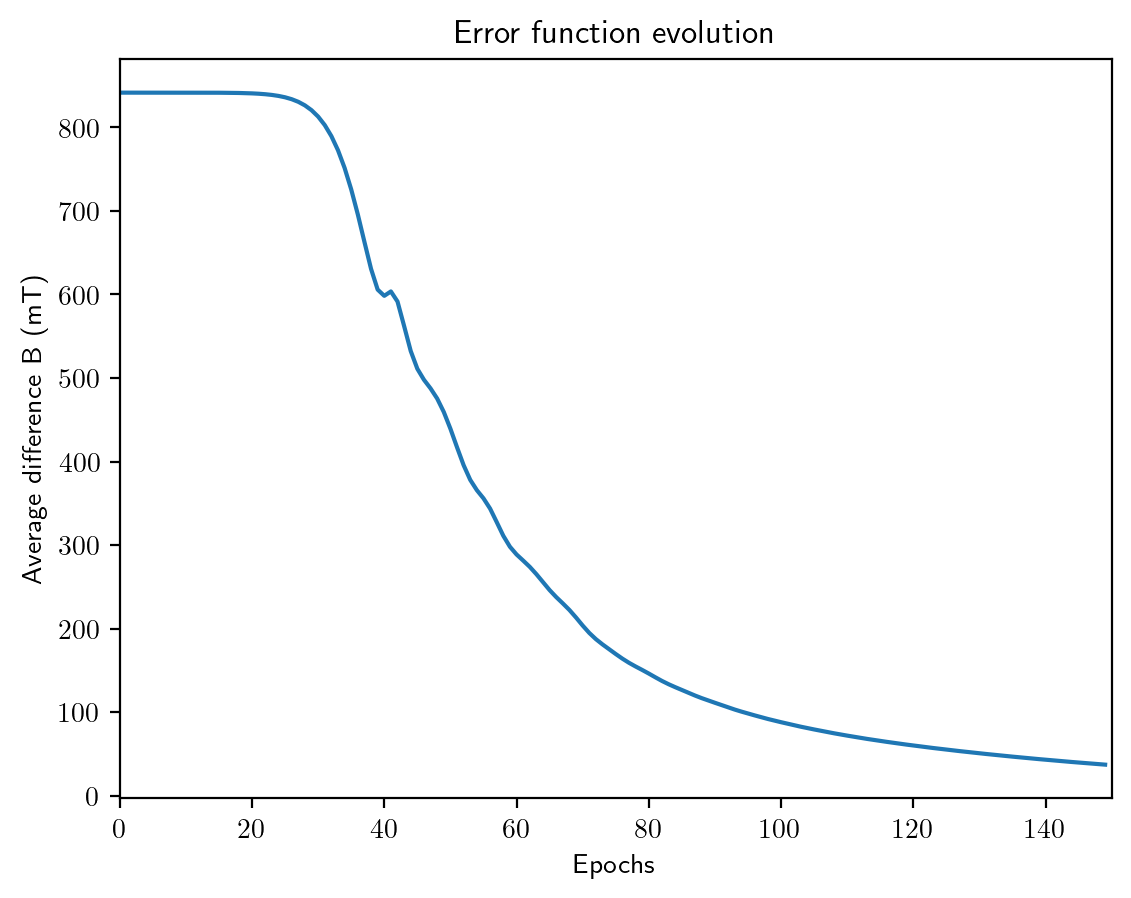

In [ ]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


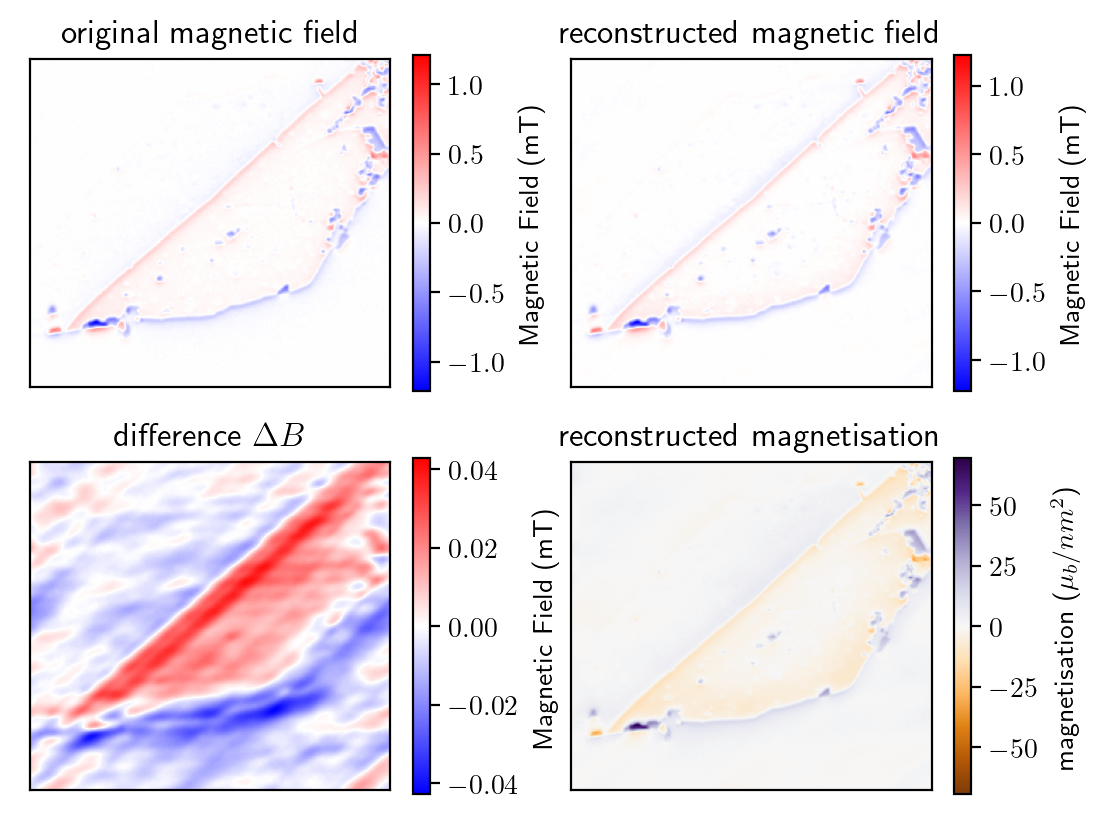

In [ ]:
FittingMethod.extract_results()

FittingMethod.plot_results()

Text(0.5, 1.0, 'Difference')

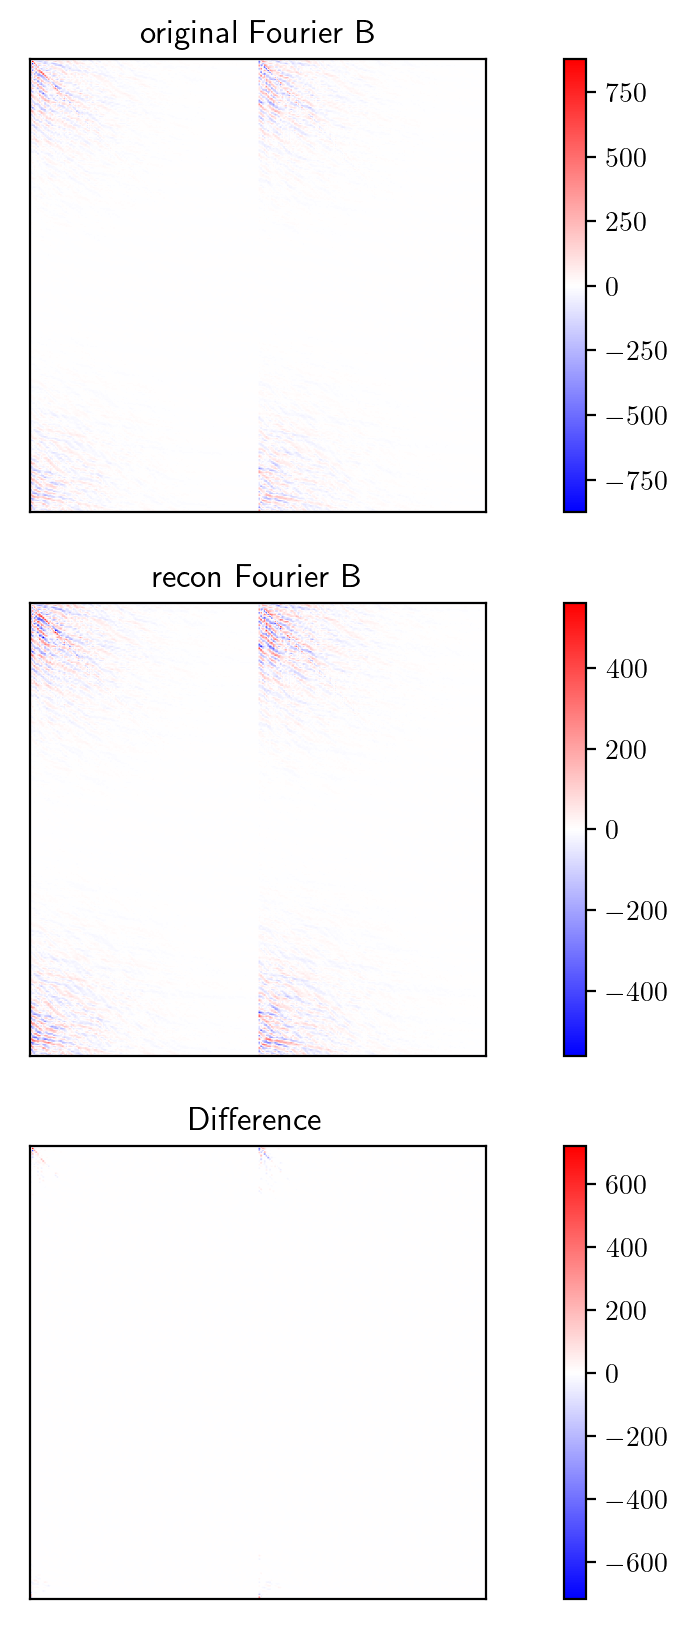

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(3, 1, 1)
plot_data = FittingMethod.img_comp[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('original Fourier B')

plt.subplot(3, 1, 2)
plot_data = FittingMethod.final_b[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('recon Fourier B')

plt.subplot(3, 1, 3)
plot_data = FittingMethod.img_comp[0,0,::] - FittingMethod.final_b[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('Difference')



In [ ]:
FittingMethod.final_b[0,0,::]

tensor([[ 0.0000e+00, -6.2994e+01, -1.1450e+02,  ..., -2.1790e+00,
         -9.7079e-01, -1.4954e-02],
        [-4.3736e+01,  1.5640e+02,  6.1968e+01,  ...,  2.5515e+00,
         -1.9557e+00,  3.0231e-01],
        [ 1.8640e+02, -2.1029e+02,  2.1904e+02,  ...,  2.0315e+00,
          4.1940e+00,  2.4526e+00],
        ...,
        [ 8.5088e+01, -1.5548e+02, -7.7070e+01,  ...,  1.5552e+00,
          4.3178e-02,  3.0404e-02],
        [ 1.8574e+02, -6.0874e+01, -1.4776e+02,  ..., -2.6353e+00,
          2.5662e-01, -2.5091e+00],
        [-4.4170e+01,  3.8911e+01,  1.2784e-01,  ...,  5.8015e-01,
         -9.4469e-01, -2.8670e-01]])